# Stochastic Variational Inference in Sparse GP fails to Learn Bi-modal Noise Variance

This notebook utilises GPflow to implement stochastic variational inference in sparse GPs. More specifically, it compares its application to a constant (or zero) noise data set with a data set containing bi-modal noise structure. The notebook shows how stochastic variational inference in sparse GPs handles data sets with bi-modal noise structure (not well).

In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import gpflow as gpflow
import random
import matplotlib.pyplot as plt
plt.style.use('ggplot')

W0821 16:10:12.122408 4554626496 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0821 16:10:12.124675 4554626496 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/misc.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0821 16:10:12.260421 4554626496 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/training/tensorflow_optimizer.py:169: The name tf.train.AdadeltaOptimizer is deprecated. Please use tf.compat.v1.train.AdadeltaOptimizer instead.

W0821 16:10:12.261169 4554626496 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/training/tensorflow_optimizer.py:156: The name tf.train.Optimizer is deprecated. Please use 

Lets create a function to represent our mapping $f$.

In [2]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

Lets now generate a set of constant/zero noise observations $\{(\mathbf{x}_n, \mathbf{y}_n)\}^N_{n=1}$ using this function $\mathbf{y} = f(\mathbf{x})$.

In [3]:
# N = 1000 # Number of training observations

# # X = rnd.rand(N, 1) * 2 - 1 # X values
# X = np.linspace(-1.0, 1.0, N)[:, None]
# Y = np.empty(X.shape)
# Y = func(X) + 0.2 * rnd.randn(N, 1) # Noisy Y values
N = 1000 # number of training observations

# generate input observations X
# X = rnd.rand(N, 1) * 2 - 1 # X values
X = np.linspace(-1.0, 1.0, N)[:, None]

# generate target observations Y
Y = np.zeros([N, 1])
# Y = func(X)
Y = func(X) + 0.05 * rnd.randn(1000,1)
Y[-200:] += 0.2 * rnd.randn(200,1) # add noise to subset of target observations Y
Y[:200] += 0.2 * rnd.randn(200,1) # add noise to subset of target observations Y

# Bernoulli indicator variable, 0 = low noise, 1 = high noise
a = np.zeros([N, 1])
a[-200:] = 1
a[:200] = 1

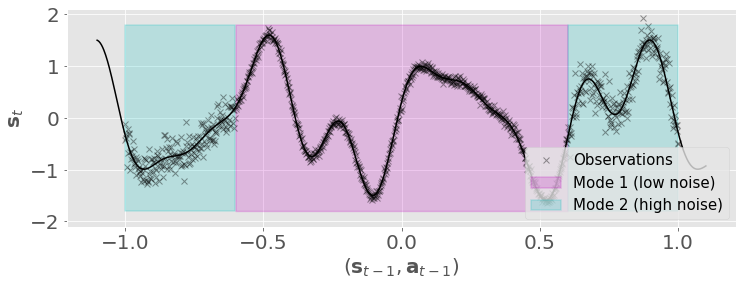

In [4]:
# plt.plot(X, Y, 'x', alpha=0.6)
# D = X.shape[1]
# Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
# Yt = func(Xt)
# plt.plot(Xt, Yt, c='k');
plt.figure(figsize=(12, 4))
plt.plot(X, Y, 'x', color='k', alpha=0.4, label="Observations")
plt.fill_between(X[:200, 0], -1.8, 1.8, color='c', alpha=0.2, lw=1.5)
plt.fill_between(X[a==0], -1.8, 1.8, color='m', alpha=0.2, lw=1.5, label='Mode 1 (low noise)')
plt.fill_between(X[-200:, 0], -1.8, 1.8, color='c', alpha=0.2, lw=1.5, label='Mode 2 (high noise)')
# plt.plot(X, a, '.', alpha=0.6, label="$\\alpha$")
D = X.shape[1]
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
plt.plot(Xt, Yt, c='k')#, label="Underlying function"
plt.xlabel("$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$", fontsize=20)
plt.ylabel("$\mathbf{s}_t$", fontsize=20)
plt.tick_params(labelsize=20)
plt.ylim(-2.1, 2.1)
plt.legend(loc='lower right', fontsize=15)
plt.savefig("img/dataset.pdf", transparent=True, bbox_inches='tight')

Lets now initialise $M$ inducing input locations $\mathbf{X}_u$ from our training inputs $\mathbf{X}$.

In [5]:
M = 50 # number of inducing locations
Z = np.array(random.sample(list(X), M)) # initialisation of inducing input locations (M random points from the training inputs)

We can now create a simple RBF kernel and initialise out our sparse variational GP using gpflow.

In [6]:
k = gpflow.kernels.RBF(input_dim=D)
# k.as_pandas_table()
m = gpflow.models.SVGP(X, Y, k, gpflow.likelihoods.Gaussian(), Z, minibatch_size=len(X)) #, minibatch_size=len(Z))
# m.as_pandas_table()

W0821 16:10:15.553570 4554626496 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/core/node.py:109: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 16:10:15.569576 4554626496 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/params/parameter.py:388: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 16:10:15.571501 4554626496 deprecation_wrapper.py:119] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/gpflow/params/parameter.py:394: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0821 16:10:15.614649 4554626496 deprecation.py:323] From /Users/aidanscannell/.virtualenvs/bmsmgp/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

## Likelihood computation: Batch vs. Minibatch
First we showcase the model's performance using the whole dataset to compute the ELBO.

In [7]:
%%timeit
m.compute_log_likelihood()

4.21 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can speed up this calculation by using minibatches of the data. For this example, we use minibatched of size 100.

In [8]:
minibatch_size = 100
ground_truth = m.compute_log_likelihood()
m.X.set_batch_size(minibatch_size)
m.Y.set_batch_size(minibatch_size)

In [9]:
%%timeit
m.compute_log_likelihood()

2.41 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The reason to use minibatches is that it decreases the time needed to make an optimisation step, since estimating the objective is computationally cheaper with fewer datapoints. Smaller minibatches result in a cheaper estimate of the objective.

## Stochastic Optimisation
First we create a utility function that plots the models predictions:

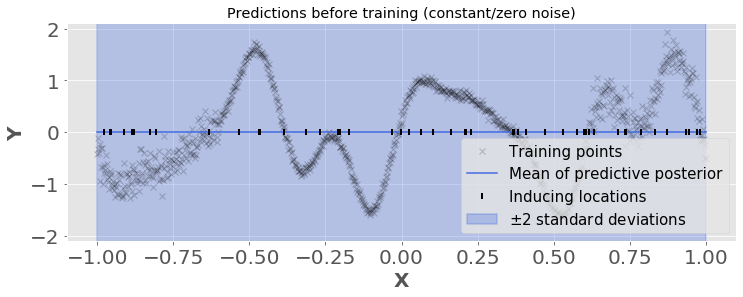

In [10]:
def plot(title=""):
    plt.figure(figsize=(12, 4))
    pX = np.linspace(-1, 1, 100)[:, None] # Test locations
    pY, pYv = m.predict_y(pX) # Predict Y values at test locations
    plt.plot(X, Y, 'x', color='k', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, color='royalblue', lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
#     plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color=col, alpha=0.6, lw=1.5)
    plt.plot(m.feature.Z.value, np.zeros(m.feature.Z.value.shape), 'k|', mew=2, label='Inducing locations')
#     plt.xlabel("$\mathbf{X}$")
#     plt.ylabel("$\mathbf{Y}$")
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color=col, alpha=0.3, lw=1.5, label='$\pm 2$ standard deviations')
    plt.legend(loc='lower right', fontsize=15)
    plt.xlabel("$\mathbf{X}$", fontsize=20)
    plt.ylabel("$\mathbf{Y}$", fontsize=20)
    plt.tick_params(labelsize=20)
    plt.ylim(-2.1, 2.1)
    plt.title(title)

plot("Predictions before training (constant/zero noise)")

To plot the optmisation trace, we create a GPflow `Action` object. This object stores the model as well as a list of its log-likelihood (ELBO) at certain points in the optimisation.

In [11]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

Now we can train our model. For optimising the ELBO, we use the Adam Optimiser *(Kingma and Ba 2015)* which is designed for stochastic objective functions. We create a utility function `run_adam` to perform the optimisation.

In [12]:
minibatch_size = 100
m.X.set_batch_size(minibatch_size)
m.Y.set_batch_size(minibatch_size)

# We turn of training for inducing point locations
m.feature.trainable = False

def run_adam(model, iterations):
    """
    Utility function running the Adam Optimiser interleaved with a `Logger` action.
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=iterations)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

Now we run the optimisation loop for 10000 iterations.

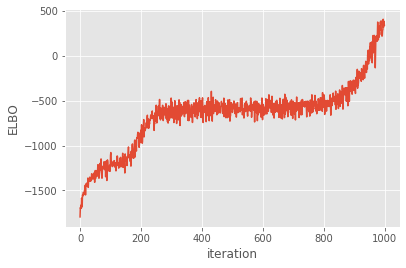

In [13]:
logger = run_adam(m, gpflow.test_util.notebook_niter(10000))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO');

Finally, we plot the model's predictions.

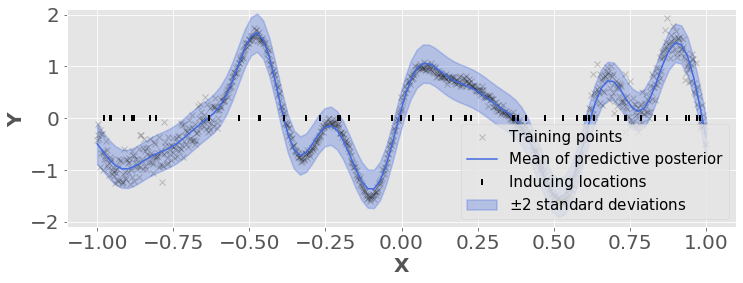

In [14]:
# plot("Predictions after training (constant/zero noise)")
plot("")
plt.savefig("img/unimode.pdf", transparent=True)

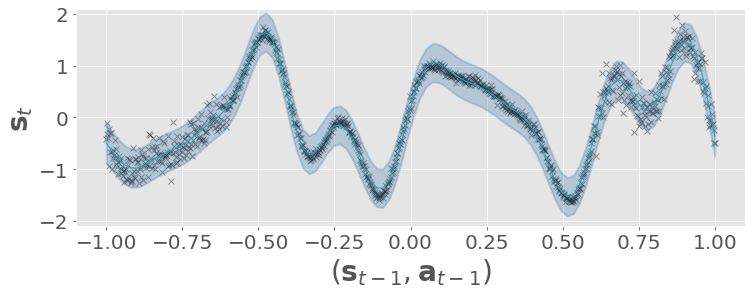

In [16]:
# fig = plt.figure(figsize=(12, 8))
# fig.add_subplot(211)

# plt.plot(X, Y, 'x', alpha=0.6, label="Observations")
# plt.plot(X, a, '-', color='k', alpha=0.6, label="$\\alpha$")
# D = X.shape[1]
# Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
# Yt = func(Xt)
# # plt.plot(Xt, Yt, c='k', label="Underlying function")
# plt.xlabel("$\mathbf{X}$")
# plt.ylabel("$\mathbf{Y}$")
# plt.legend()

# fig.add_subplot(212)
fig = plt.figure(figsize=(12, 4))
pX = np.linspace(-1, 1, 100)[:, None] # Test locations
pY, pYv = m.predict_y(pX) # Predict Y values at test locations
# plt.plot(X, Y, 'x', color='darkgreen', alpha=0.2)
plt.plot(X, Y, 'x', color='k', label='Training points', alpha=0.4)
# plt.plot(X, a, '-', color='k', alpha=0.6, label="$\\alpha$")
# line, = plt.plot(pX, pY, color='olive', lw=1.5, label='Mean of predictive posterior')
plt.plot(pX, pY, 'c-', lw=1)
# col = line.get_color()
# plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color=col, alpha=0.4, lw=1.5, label='$\pm 2$ standard deviations')
plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color='steelblue', alpha=0.3, lw=2, label='Dynamics GP', zorder=10)
# plt.legend(loc='lower right', fontsize=15)
# plt.xlabel("$\mathbf{X}$", fontsize=20)
# plt.ylabel("$\mathbf{Y}$", fontsize=20)
plt.xlabel("$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$", fontsize=28)
plt.ylabel("$\mathbf{s}_t$", fontsize=28)
plt.tick_params(labelsize=20)
plt.ylim(-2.1, 2.1)
    
plt.savefig("img/problem.pdf", transparent=True, bbox_inches='tight')

## Bi-Modal Noise
Lets now repeat the same process for a data set that contains two different noise levels.

In [46]:
Y = np.empty(X.shape)
Y = func(X) #+ 0.2 * rnd.randn(N, 1) # Noisy Y values
Y[-200: ] += 0.2 * rnd.randn(200, 1) # Noisy Y values

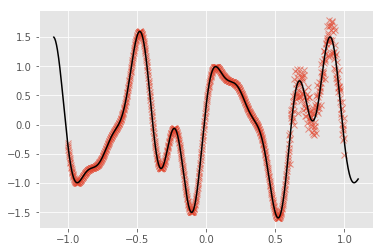

In [47]:
plt.plot(X, Y, 'x', alpha=0.6)
D = X.shape[1]
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
plt.plot(Xt, Yt, c='k');

In [48]:
k = gpflow.kernels.RBF(input_dim=D)
lik = gpflow.likelihoods.Gaussian()
m = gpflow.models.SVGP(X, Y, k, lik, Z, minibatch_size=len(X)) #, minibatch_size=len(Z))

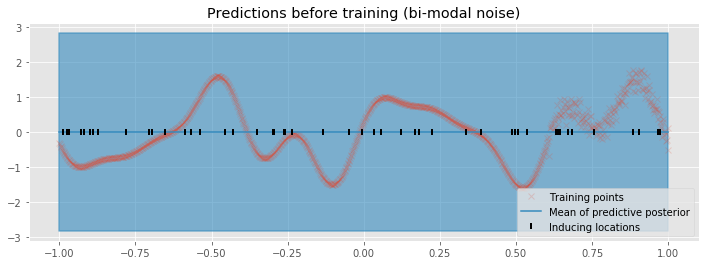

In [49]:
plot("Predictions before training (bi-modal noise)")

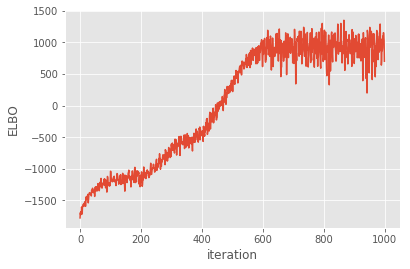

In [50]:
minibatch_size = 100
m.X.set_batch_size(minibatch_size)
m.Y.set_batch_size(minibatch_size)

# We turn of training for inducing point locations
m.feature.trainable = False

logger = run_adam(m, gpflow.test_util.notebook_niter(10000))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO');

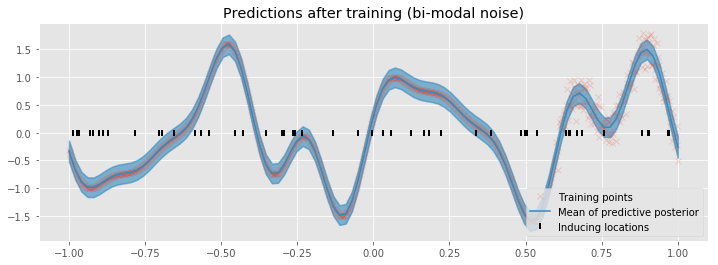

In [51]:
plot("Predictions after training (bi-modal noise)")

It is clear that the stochastic variational inference sparse GP is not capable of modelling and thus learning bi-modal noise. Instead it models noise in what should be noise free regions and under estimates noise in regions with high noise.